# Analyzing Adidas store dataset

## Imports 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import sqlite3
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier


## Read Data

In [2]:

df1 = pd.read_csv('country_dim.csv')
df2 = pd.read_csv('shoes_dim.csv')
df3 = pd.read_csv('shoes_fact.csv')

df1.head()


,country_code,currency,shoe_metric
0,DE,euro,eu
1,US,usd,usa
2,BE,euro,eu
3,UK,pounds,uk


In [3]:
df2.head()

,id,name,best_for_wear,gender,image_url,dominant_color,sub_color1,sub_color2
0,HP9426,Breaknet 2.0 Schuh,City,U,"https://assets.adidas.com/images/w_600,f_auto,...",Cloud White,Core Black,Cloud White
1,HQ4199,Ultraboost 1.0 Laufschuh,City,U,"https://assets.adidas.com/images/w_600,f_auto,...",Core Black,Core Black,Beam Green
2,JQ2552,Adizero Boston 12 Laufschuh,Racing,U,"https://assets.adidas.com/images/w_600,f_auto,...",Cloud White,Core Black,Lucid Red
3,JI1896,NY 90 Schuh,Neutral,U,"https://assets.adidas.com/images/w_600,f_auto,...",Cloud White,Cloud White,Crystal White
4,IE8976,Ultraboost 1.0 Laufschuh,Neutral,U,"https://assets.adidas.com/images/w_600,f_auto,...",Grey One,Grey Three,Grey One


In [4]:

df3.head()

,Unnamed: 0,id,price,category,size,availability,date,country_code
0,63575,HP9426,60.0,sneakers,36,0,07/01/2025,DE
1,63576,HP9426,60.0,sneakers,36 2/3,0,07/01/2025,DE
2,63577,HP9426,60.0,sneakers,37 1/3,0,07/01/2025,DE
3,63578,HP9426,60.0,sneakers,38,0,07/01/2025,DE
4,63579,HP9426,60.0,sneakers,38 2/3,1,07/01/2025,DE


In [5]:
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

df1.to_sql('tabela1', conn, index=False, if_exists='replace')
df2.to_sql('tabela2', conn, index=False, if_exists='replace')
df3.to_sql('tabela3', conn, index=False, if_exists='replace')


299156

## Analyzing dataset

In [6]:

cursor.execute("PRAGMA table_info(tabela3);")
colunas = cursor.fetchall()
print("Estrutura original da tabela3:")
for coluna in colunas:
    print(coluna)

colunas_para_manter = [col[1] for col in colunas if col[1] != "Unnamed: 0"]
colunas_para_manter_str = ", ".join(colunas_para_manter)

cursor.execute(f"CREATE TABLE tabela3_nova AS SELECT {colunas_para_manter_str} FROM tabela3;")
conn.commit()

cursor.execute("DROP TABLE tabela3;")
conn.commit()

cursor.execute("ALTER TABLE tabela3_nova RENAME TO tabela3;")
conn.commit()

cursor.execute("PRAGMA table_info(tabela3);")
nova_estrutura = cursor.fetchall()
print("\nNova estrutura da tabela3:")
for coluna in nova_estrutura:
    print(coluna)


Estrutura original da tabela3:
(0, 'Unnamed: 0', 'INTEGER', 0, None, 0)
(1, 'id', 'TEXT', 0, None, 0)
(2, 'price', 'REAL', 0, None, 0)
(3, 'category', 'TEXT', 0, None, 0)
(4, 'size', 'TEXT', 0, None, 0)
(5, 'availability', 'INTEGER', 0, None, 0)
(6, 'date', 'TEXT', 0, None, 0)
(7, 'country_code', 'TEXT', 0, None, 0)

Nova estrutura da tabela3:
(0, 'id', 'TEXT', 0, None, 0)
(1, 'price', 'REAL', 0, None, 0)
(2, 'category', 'TEXT', 0, None, 0)
(3, 'size', 'TEXT', 0, None, 0)
(4, 'availability', 'INT', 0, None, 0)
(5, 'date', 'TEXT', 0, None, 0)
(6, 'country_code', 'TEXT', 0, None, 0)


In [7]:
consulta = '''
SELECT country_code, COUNT(*) as total_registros
FROM tabela3
GROUP BY country_code
ORDER BY total_registros DESC;
'''

df_contagem_pais = pd.read_sql_query(consulta, conn)
print(df_contagem_pais)


  country_code  total_registros
0           DE           216202
1           US            53368
2           BE            26453
3           UK             3133


In [8]:
colunas_para_manter = [col[1] for col in colunas if col[1] != "Unnamed: 0"]
colunas_para_manter_str = ", ".join(colunas_para_manter)


cursor.execute(f"CREATE TABLE tabela3_nova AS SELECT {colunas_para_manter_str} FROM tabela3;")
conn.commit()

In [9]:
cursor.execute("DROP TABLE tabela3;")
conn.commit()

cursor.execute("ALTER TABLE tabela3_nova RENAME TO tabela3;")
conn.commit()


In [10]:
cursor.execute("PRAGMA table_info(tabela3);")
nova_estrutura = cursor.fetchall()
print("\nNova estrutura da tabela3:")
for coluna in nova_estrutura:
    print(coluna)



Nova estrutura da tabela3:
(0, 'id', 'TEXT', 0, None, 0)
(1, 'price', 'REAL', 0, None, 0)
(2, 'category', 'TEXT', 0, None, 0)
(3, 'size', 'TEXT', 0, None, 0)
(4, 'availability', 'INT', 0, None, 0)
(5, 'date', 'TEXT', 0, None, 0)
(6, 'country_code', 'TEXT', 0, None, 0)


In [11]:
consulta_sql = '''
SELECT
    t1.*,    -- Todas as colunas de tabela1
    t2.*,    -- Todas as colunas de tabela2
    t3.*     -- Todas as colunas de tabela3
FROM
    tabela1 t1
INNER JOIN
    tabela3 t3 ON t1.country_code = t3.country_code
INNER JOIN
    tabela2 t2 ON t3.id = t2.id
;
'''

In [12]:
cursor.execute("DELETE FROM tabela3 WHERE availability = 0;")

conn.commit()


## Análise Exploratória de Dados (EDA)

In [13]:
df_unido = pd.read_sql_query(consulta_sql, conn)

print("\nDados após a junção das tabelas:")
print(df_unido.head())

df_unido.to_csv('output/resultado_unido.csv', index=False)

conn.commit()


Dados após a junção das tabelas:
  country_code currency shoe_metric      id                    name  \
0           DE     euro          eu  011040         World Cup Boots   
1           DE     euro          eu  011040  World Cup Fußballschuh   
2           DE     euro          eu  011040         World Cup Boots   
3           DE     euro          eu  011040  World Cup Fußballschuh   
4           DE     euro          eu  011040         World Cup Boots   

  best_for_wear gender                                          image_url  \
0       Stadium      U  https://assets.adidas.com/images/w_600,f_auto,...   
1       Stadium      U  https://assets.adidas.com/images/w_600,f_auto,...   
2       Stadium      U  https://assets.adidas.com/images/w_600,f_auto,...   
3       Stadium      U  https://assets.adidas.com/images/w_600,f_auto,...   
4       Stadium      U  https://assets.adidas.com/images/w_600,f_auto,...   

  dominant_color      sub_color1 sub_color2      id  price        category  

In [14]:
print(df_unido.describe())

print(df_unido.isnull().sum())

print(df_unido['category'].value_counts())


               price   availability
count  328414.000000  328414.000000
mean      108.479741      10.691627
std        60.576247       5.527195
min        16.000000       1.000000
25%        60.000000       5.000000
50%       100.000000      15.000000
75%       140.000000      15.000000
max       500.000000      15.000000
country_code        0
currency            0
shoe_metric         0
id                  0
name                0
best_for_wear       0
gender              0
image_url           0
dominant_color      0
sub_color1        203
sub_color2        503
id                  0
price               0
category            0
size                0
availability        0
date                0
country_code        0
dtype: int64
category
running-shoes           91762
sneakers                82441
outdoor-shoes           45281
walking-shoes           33964
us/athletic_sneakers    17352
gym_training-shoes      14999
tennis-shoes            14623
athletic_sneakers        8530
us/running-shoes  

In [15]:
df_unido.dropna(subset=['sub_color1', 'sub_color2'], inplace=True)

In [16]:
df_unido['category'] = df_unido['category'].str.replace("us/", "", regex=False)

df_unido['category'] = df_unido['category'].replace({'occer-shoes': 'soccer-shoes'})

df_unido['category'] = df_unido['category'].replace({'hiking-shoes': 'outdoor-shoes'})


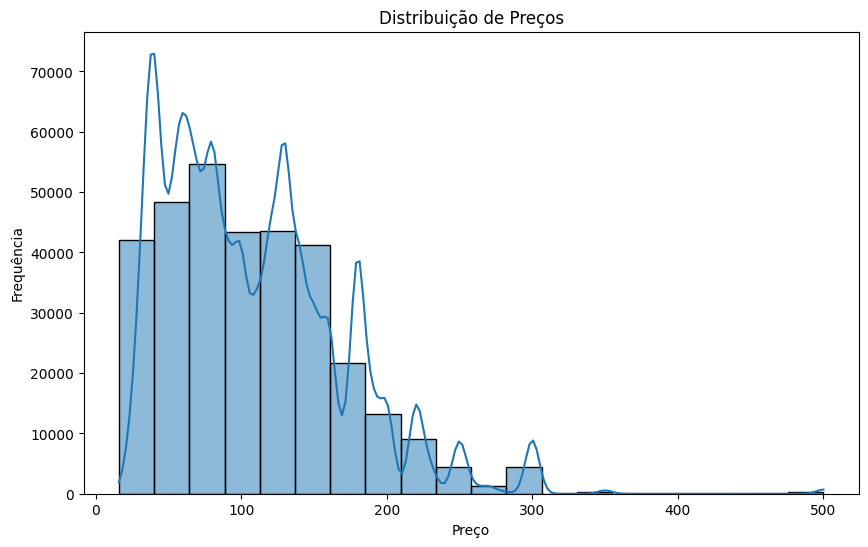

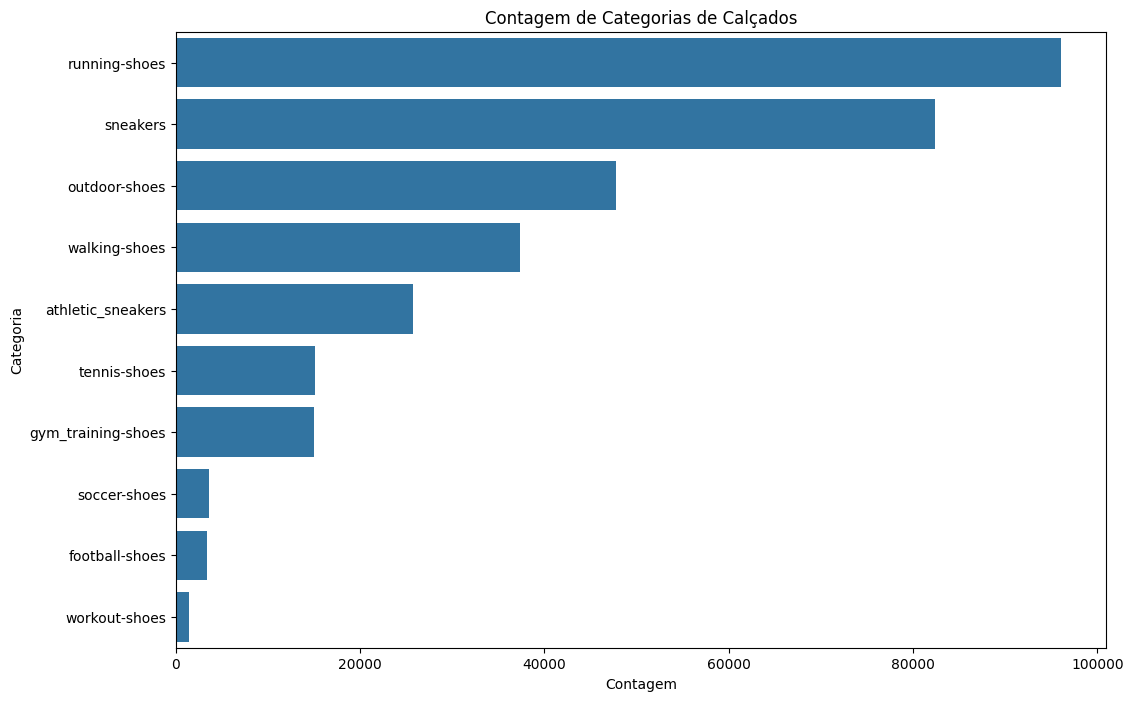

In [17]:

plt.figure(figsize=(10,6))
sns.histplot(df_unido['price'], bins=20, kde=True)
plt.title('Distribuição de Preços')
plt.xlabel('Preço')
plt.ylabel('Frequência')
plt.show()

plt.figure(figsize=(12,8))
sns.countplot(data=df_unido, y='category', order=df_unido['category'].value_counts().index)
plt.title('Contagem de Categorias de Calçados')
plt.xlabel('Contagem')
plt.ylabel('Categoria')
plt.show()


In [18]:
verify_price = '''
SELECT category, AVG(price) AS avg_price, COUNT(*) AS total_produtos
FROM tabela3
GROUP BY category
ORDER BY avg_price DESC;
'''

cursor.execute(verify_price)

resultados = cursor.fetchall()
for linha in resultados:
    print(f"Categoria: {linha[0]}, Preço Médio: {linha[1]}")

conn.commit()

Categoria: occer-shoes, Preço Médio: 140.68901927912825
Categoria: us/soccer-shoes, Preço Médio: 140.08086367485183
Categoria: us/running-shoes, Preço Médio: 131.43858267716536
Categoria: us/tennis-shoes, Preço Médio: 131.28947368421052
Categoria: us/workout-shoes, Preço Médio: 125.05515587529976
Categoria: gym_training-shoes, Preço Médio: 124.85932529278058
Categoria: running-shoes, Preço Médio: 124.68953781113433
Categoria: outdoor-shoes, Preço Médio: 122.33739339143361
Categoria: athletic_sneakers, Preço Médio: 121.14096774193548
Categoria: us/athletic_sneakers, Preço Médio: 120.25527694016823
Categoria: hiking-shoes, Preço Médio: 118.1479057591623
Categoria: us/hiking-shoes, Preço Médio: 117.53530166880616
Categoria: football-shoes, Preço Médio: 114.2188967136146
Categoria: us/walking-shoes, Preço Médio: 113.67861557478368
Categoria: tennis-shoes, Preço Médio: 110.41261261261255
Categoria: walking-shoes, Preço Médio: 91.62129284535968
Categoria: sneakers, Preço Médio: 69.8143201726

In [19]:
verify_disponibilit = '''
SELECT category, SUM(availability) AS total_stock
FROM tabela3
GROUP BY category
ORDER BY total_stock DESC;
'''

cursor.execute(verify_disponibilit)

resultados = cursor.fetchall()
for linha in resultados:
    print(f"Categoria: {linha[0]}, Desponibilidade: {linha[1]}")

conn.commit()

Categoria: sneakers, Desponibilidade: 459453
Categoria: running-shoes, Desponibilidade: 429087
Categoria: outdoor-shoes, Desponibilidade: 193083
Categoria: walking-shoes, Desponibilidade: 171097
Categoria: us/athletic_sneakers, Desponibilidade: 145453
Categoria: tennis-shoes, Desponibilidade: 74501
Categoria: athletic_sneakers, Desponibilidade: 72458
Categoria: gym_training-shoes, Desponibilidade: 61426
Categoria: us/running-shoes, Desponibilidade: 29044
Categoria: us/soccer-shoes, Desponibilidade: 27759
Categoria: us/walking-shoes, Desponibilidade: 26421
Categoria: football-shoes, Desponibilidade: 18819
Categoria: occer-shoes, Desponibilidade: 14057
Categoria: us/hiking-shoes, Desponibilidade: 10285
Categoria: hiking-shoes, Desponibilidade: 10185
Categoria: us/workout-shoes, Desponibilidade: 9371
Categoria: us/tennis-shoes, Desponibilidade: 3098


In [20]:
verify_disponibilit = '''
SELECT category, SUM(availability) AS total_stock
FROM tabela3
GROUP BY category
ORDER BY total_stock DESC;
'''

cursor.execute(verify_disponibilit)

resultados = cursor.fetchall()
for linha in resultados:
    print(f"Categoria: {linha[0]}, Desponibilidade: {linha[1]}")

conn.commit()

Categoria: sneakers, Desponibilidade: 459453
Categoria: running-shoes, Desponibilidade: 429087
Categoria: outdoor-shoes, Desponibilidade: 193083
Categoria: walking-shoes, Desponibilidade: 171097
Categoria: us/athletic_sneakers, Desponibilidade: 145453
Categoria: tennis-shoes, Desponibilidade: 74501
Categoria: athletic_sneakers, Desponibilidade: 72458
Categoria: gym_training-shoes, Desponibilidade: 61426
Categoria: us/running-shoes, Desponibilidade: 29044
Categoria: us/soccer-shoes, Desponibilidade: 27759
Categoria: us/walking-shoes, Desponibilidade: 26421
Categoria: football-shoes, Desponibilidade: 18819
Categoria: occer-shoes, Desponibilidade: 14057
Categoria: us/hiking-shoes, Desponibilidade: 10285
Categoria: hiking-shoes, Desponibilidade: 10185
Categoria: us/workout-shoes, Desponibilidade: 9371
Categoria: us/tennis-shoes, Desponibilidade: 3098


In [21]:
df_unido = df_unido.loc[:, ~df_unido.columns.duplicated()]

## Feature Engineering

In [22]:
print(df_unido['date'].head(20))  
print(df_unido['date'].unique())  

270    07/01/2025
271    07/01/2025
272    07/01/2025
273    08/01/2025
274    08/01/2025
275    08/01/2025
276    09/01/2025
277    09/01/2025
278    09/01/2025
279    10/01/2025
280    10/01/2025
281    10/01/2025
282    11/01/2025
283    11/01/2025
284    11/01/2025
285    12/01/2025
286    12/01/2025
287    12/01/2025
288    14/01/2025
289    14/01/2025
Name: date, dtype: object
['07/01/2025' '08/01/2025' '09/01/2025' '10/01/2025' '11/01/2025'
 '12/01/2025' '14/01/2025' '2025-01-15' '2025-01-16' '13/01/2025'
 '15/01/2025']


### Extração de Informações da Data (date)

In [23]:
df_unido['date'] = pd.to_datetime(df_unido['date'], format='mixed', errors='coerce')

df_unido['mes'] = df_unido['date'].dt.month
df_unido['ano'] = df_unido['date'].dt.year

print(df_unido[['date', 'mes', 'ano']].head())


          date  mes   ano
270 2025-07-01    7  2025
271 2025-07-01    7  2025
272 2025-07-01    7  2025
273 2025-08-01    8  2025
274 2025-08-01    8  2025


In [24]:
print(df_unido['date'].isnull().sum())  

0


### Criando Faixas de Preço (price)

In [25]:
bins = [0, 50, 100, 150, 200, 300, 500]
labels = ['0-50', '51-100', '101-150', '151-200', '201-300', '301+']
df_unido['price_range'] = pd.cut(df_unido['price'], bins=bins, labels=labels)

print(df_unido['price_range'].value_counts())

price_range
51-100     114725
101-150     86013
0-50        60096
151-200     47275
201-300     19191
301+          611
Name: count, dtype: int64


### Criando Indicadores de Disponibilidade

In [26]:
df_unido['in_stock'] = df_unido['availability'].apply(lambda x: 1 if x > 0 else 0)
print(df_unido[['availability', 'in_stock']].head())

     availability  in_stock
270             6         1
271             6         1
272             6         1
273             6         1
274             6         1


### Codificação de Variáveis Categóricas

In [27]:
print(type(df_unido['country_code']))  
print(df_unido['country_code'].shape)  

<class 'pandas.core.series.Series'>
(327911,)


In [28]:
df_unido['country_code'] = df_unido['country_code'].squeeze()  

In [29]:
print(df_unido[['country_code']].head())  
print(df_unido['country_code'].dtype) 
print(df_unido['country_code'].shape)  
print(df_unido['country_code'].isnull().sum())  
print(df_unido['country_code'].apply(type).value_counts())  

    country_code
270           DE
271           DE
272           DE
273           DE
274           DE
object
(327911,)
0
country_code
<class 'str'>    327911
Name: count, dtype: int64


In [30]:
df_unido = pd.get_dummies(df_unido, columns=['gender', 'price_range'], drop_first=True)

### Criando Indicadores de Popularidade

In [31]:
df_unido['country_code'] = df_unido['country_code'].astype(str)  
df_unido['country_code'] = df_unido['country_code'].squeeze()    

In [32]:
print(df_unido['country_code'].isnull().sum())  

0


In [33]:
print(df_unido['country_code'].apply(type).value_counts())  

country_code
<class 'str'>    327911
Name: count, dtype: int64


In [34]:
df_unido['country_code'] = df_unido['country_code'].astype(str)

In [35]:
df_unido['category_count'] = df_unido.groupby('category')['category'].transform('count')
df_unido['country_product_count'] = df_unido.groupby('country_code')['country_code'].transform('count')

print(df_unido[['category', 'category_count', 'country_code', 'country_product_count']].head())

           category  category_count country_code  country_product_count
270  football-shoes            3363           DE                 243940
271  football-shoes            3363           DE                 243940
272  football-shoes            3363           DE                 243940
273  football-shoes            3363           DE                 243940
274  football-shoes            3363           DE                 243940


### Criando Interações Entre Features

In [36]:
df_unido['price_per_avail'] = df_unido['price'] / (df_unido['availability'] + 1)  
print(df_unido[['price', 'availability', 'price_per_avail']].head())


     price  availability  price_per_avail
270  180.0             6        25.714286
271  180.0             6        25.714286
272  180.0             6        25.714286
273  180.0             6        25.714286
274  180.0             6        25.714286


## Machine Learning

### Feature Importances

In [37]:


df_model = df_unido.copy()

colunas_para_remover = ['price', 'id', 'name', 'image_url', 'date']
X = df_model.drop(columns=colunas_para_remover)

X = pd.get_dummies(X, drop_first=True)

y = df_model['price']

modelo = RandomForestRegressor(n_estimators=100, random_state=42)
modelo.fit(X, y)

importances = modelo.feature_importances_
features = X.columns

df_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
df_importances = df_importances.sort_values(by='Importance', ascending=False)


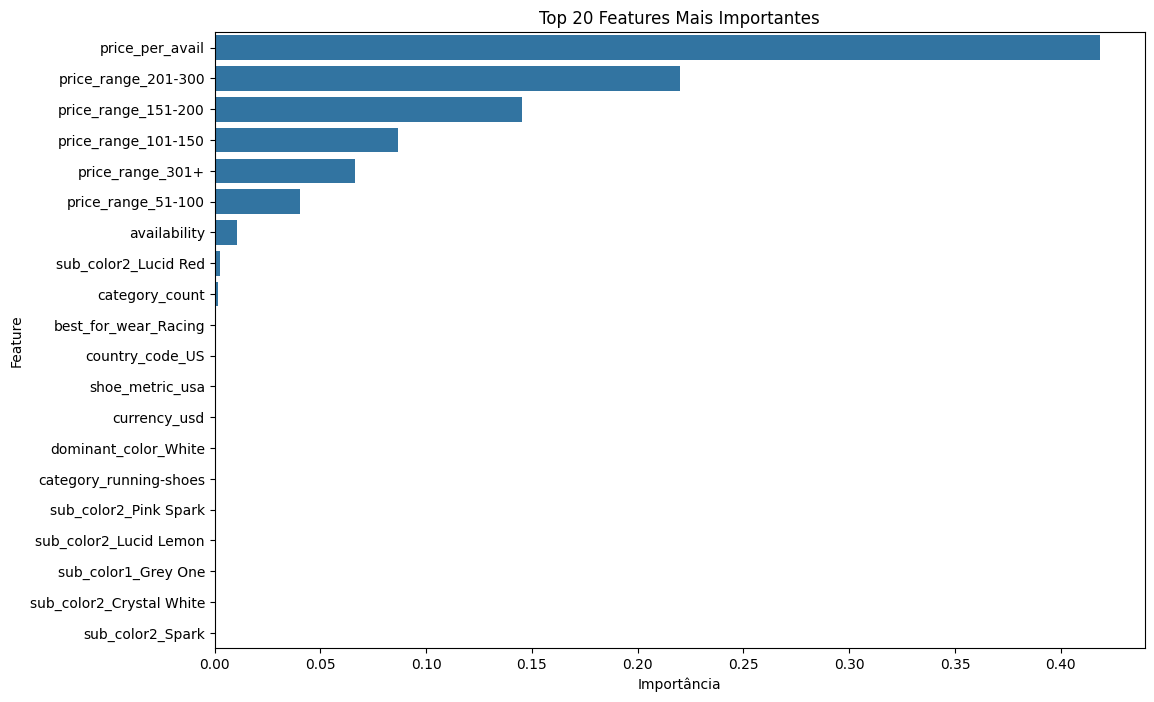

In [38]:

top_n = 20
df_top_features = df_importances.head(top_n)

plt.figure(figsize=(12, 8))
sns.barplot(x=df_top_features['Importance'], y=df_top_features['Feature'])
plt.title(f"Top {top_n} Features Mais Importantes")
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.show()


In [39]:

features_para_remover = ['in_stock', 'category_count', 'country_product_count']  
X = X.drop(columns=features_para_remover)

print("Features restantes após limpeza:", X.columns)


Features restantes após limpeza: Index(['availability', 'mes', 'ano', 'gender_M', 'gender_U', 'gender_W',
       'price_range_51-100', 'price_range_101-150', 'price_range_151-200',
       'price_range_201-300',
       ...
       'size_M 5 / W 6', 'size_M 5.5 / W 6.5', 'size_M 6 / W 7',
       'size_M 6.5 / W 7.5', 'size_M 7 / W 8', 'size_M 7.5 / W 8.5',
       'size_M 8 / W 9', 'size_M 8.5 / W 9.5', 'size_M 9 / W 10',
       'size_M 9.5 / W 10.5'],
      dtype='object', length=861)


In [40]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Erro Quadrático Médio (MSE): {mse:.2f}')
print(f'Coeficiente de Determinação (R²): {r2:.2f}')


Erro Quadrático Médio (MSE): 0.18
Coeficiente de Determinação (R²): 1.00


### Transform column availability in variable binary

In [52]:
df_unido['vai_faltar'] = df_unido['availability'].apply(lambda x: 1 if x <= 2 else 0)


X_class = df_unido.drop(['availability', 'vai_faltar', 'id', 'name', 'image_url', 'date', 'price'], axis=1)
y_class = df_unido['vai_faltar']


In [53]:
print(df_unido['vai_faltar'].value_counts())


vai_faltar
0    275785
1     52126
Name: count, dtype: int64


In [54]:

X_class = pd.get_dummies(X_class, drop_first=True)


In [57]:

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

modelo_estoque = RandomForestClassifier(n_estimators=42, max_depth=10, random_state=42)
modelo_estoque.fit(X_train_class, y_train_class)

y_pred_class = modelo_estoque.predict(X_test_class)

acc = accuracy_score(y_test_class, y_pred_class)
print(f'Acurácia do modelo: {acc:.2f}')
print(classification_report(y_test_class, y_pred_class))


Acurácia do modelo: 0.85
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     55190
           1       0.99      0.04      0.07     10393

    accuracy                           0.85     65583
   macro avg       0.92      0.52      0.49     65583
weighted avg       0.87      0.85      0.78     65583

